# Preprocess GPS data to compute cumulative strain

In this notebook, we renew the reference location of GPS stations from the .neu file.
We output the `BP_GPSstations.txt` for the table of GPS locations within the study region.

2023.1.24 Kurama Okubo

- 2023.5.1 update for the archived dataset in 2023/04/16

In [1]:
import datetime
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py
import glob

import shutil
from tqdm import tqdm

os.environ['TZ'] = 'GMT' # change time zone to avoid confusion in unix_tvec conversion

plt.rcParams["font.family"] = 'Arial'
# plt.rcParams["font.sans-serif"] = "DejaVu Sans, Arial, Helvetica, Lucida Grande, Verdana, Geneva, Lucid, Avant Garde, sans-serif"
plt.rcParams["font.size"] = 12
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["xtick.major.size"] = 5
plt.rcParams["xtick.major.width"] = 0.5
plt.rcParams["xtick.minor.size"] = 0
plt.rcParams["xtick.minor.width"] = 0
plt.rcParams["xtick.minor.visible"] = True


plt.rcParams["ytick.direction"] = "in"
plt.rcParams["ytick.major.size"] = 5
plt.rcParams["ytick.major.width"] = 0.5
plt.rcParams["ytick.minor.size"] = 2
plt.rcParams["ytick.minor.width"] = 1
plt.rcParams["ytick.minor.visible"] = True


# Read MEaSures ESESES position data

Download the time series from:

http://garner.ucsd.edu/pub/measuresESESES_products/Timeseries/WesternNorthAmerica/previous/sopac/WNAM_Clean_TrendNeuTimeSeries_sopac_20230416.tar.gz

See the homepage for details:

http://sopac-csrc.ucsd.edu/index.php/sopac/

You need to unzip before processing the time series:

`find ./ -name \*.Z -exec unzip {} \;`

In [2]:
output_imgdir = "../figure"
if not os.path.exists(output_imgdir):
    os.makedirs(output_imgdir)

In [3]:
# glob the file names
WNAMfiles = np.sort(glob.glob("../data/WNAM_Clean_TrendNeuTimeSeries_sopac_20230416/*.neu"))

In [4]:
df_station = pd.DataFrame(columns=['stnm', 'lon', 'lat', 'startyear', 'startdoy', 'endyear', 'enddoy'])
for finame in WNAMfiles:
#     finame = WNAMfiles[101]
    #1. parse the station name and location
    with open(finame, 'rt') as fi:
        for line in fi:
            if "Site" in line:
                site = line.split(":")[1].strip()[0:4]
#                 print(site)
            if "Latitude" in line:
                lat = float(line.split(":")[1])
            if "Longitude" in line:
                lon = float(line.split(":")[1]) - 360

    #2. parse the start and end of year
    df_neu = pd.read_csv(finame, comment="#", header=None, delim_whitespace=True)
    
    startyear = df_neu[1][0]
    startdoy = df_neu[2][0]
    endyear = df_neu[1].tail(1).values[0]
    enddoy = df_neu[2].tail(1).values[0]

    df_tmp = pd.DataFrame(data=[[site, lon, lat, startyear, startdoy, endyear, enddoy]], 
                          columns=['stnm', 'lon', 'lat', 'startyear', 'startdoy', 'endyear', 'enddoy'])
    df_station = pd.concat([df_station, df_tmp])

In [5]:
df_station.head()

,stnm,lon,lat,startyear,startdoy,endyear,enddoy
0,7odm,-117.093192,34.116407,2001,110,2021,62
0,ab01,-174.204756,52.209505,2007,138,2022,337
0,ab02,-168.854670,52.970606,2007,143,2023,98
0,ab06,-163.423454,54.885323,2005,226,2023,98
0,ab07,-160.476757,55.349277,2004,297,2023,98


In [6]:
maxlon=-119.5
minlon=-121.4
maxlat=36.6
minlat=35.4

df_BP = df_station[(minlon<df_station["lon"]) & (df_station["lon"]<maxlon) & (minlat<df_station["lat"]) & (df_station["lat"]<maxlat)]
df_BP.index = range(len(df_BP))

In [7]:
df_BP

,stnm,lon,lat,startyear,startdoy,endyear,enddoy
0,cam5,-121.042907,35.529263,2019,330,2023,98
1,cand,-120.433695,35.939352,1999,232,2021,180
2,carh,-120.430818,35.888383,2001,221,2021,180
3,carr,-120.430834,35.888349,1992,309,2003,112
4,crbt,-120.750751,35.791610,2001,256,2023,98
...,...,...,...,...,...,...,...
78,pomm,-120.478432,35.919909,1999,233,2021,180
79,qcy2,-121.137346,36.161065,2012,366,2023,98
80,rnch,-120.524823,35.899993,2001,219,2023,98
81,shn5,-120.347059,35.674244,2015,335,2023,97


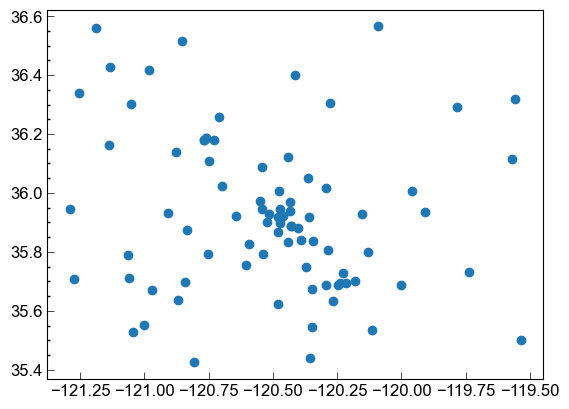

In [8]:
plt.plot(df_BP["lon"], df_BP["lat"], "o")

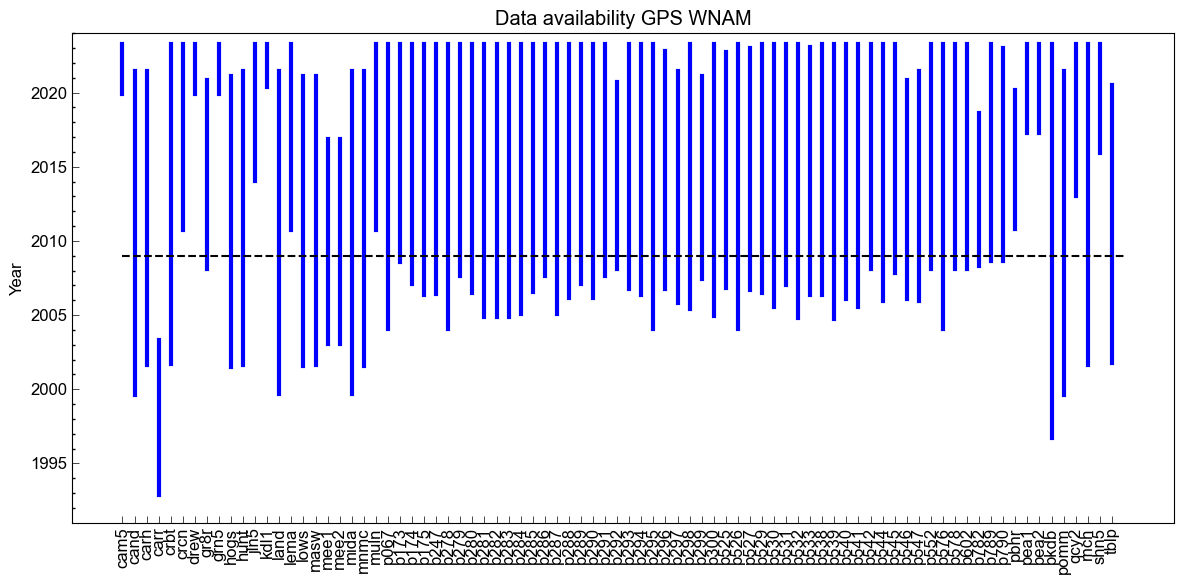

In [9]:
reference_year = 2009 # reference time stamp to compute the relative accumulation of strain

fig, ax = plt.subplots(1, 1, figsize=(12,6))

xticklabels = []
for i, row in df_BP.iterrows():
    st = float(row.startyear) + float(row.startdoy)/365
    et = float(row.endyear) + float(row.enddoy)/365
    
    ax.plot([i, i], [st, et], "b-", lw=3)
    xticklabels.append(row.stnm)

ax.plot([0, len(df_BP)], [reference_year, reference_year], "k--")
ax.set_xticks(range(len(df_BP)))
ax.set_xticklabels(xticklabels, rotation=90, ha='center');

ax.set_ylabel("Year")
ax.set_ylim([1991, 2024])
ax.set_title("Data availability GPS WNAM")

fig.tight_layout()
foname = (output_imgdir+"/GPS_Dataavailability_all.png")
plt.savefig(foname, dpi=150)

In [10]:
df_BP_ref1 = df_BP[(df_BP["startyear"] < reference_year) & (df_BP["endyear"] > reference_year)]
df_BP_ref1.index = range(len(df_BP_ref1))

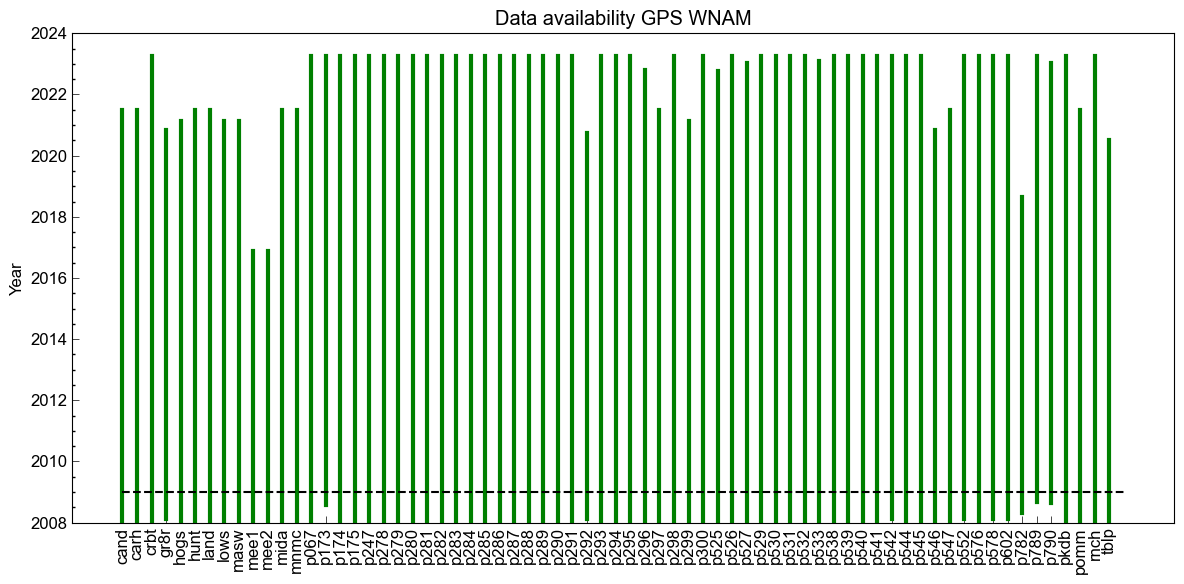

In [11]:
reference_year = 2009 # reference time stamp to compute the relative accumulation of strain

fig, ax = plt.subplots(1, 1, figsize=(12,6))

xticklabels = []
for i, row in df_BP_ref1.iterrows():
    st = float(row.startyear) + float(row.startdoy)/365
    et = float(row.endyear) + float(row.enddoy)/365
    
    ax.plot([i, i], [st, et], "g-", lw=3)
    xticklabels.append(row.stnm)

ax.plot([0, len(df_BP_ref1)], [reference_year, reference_year], "k--")
ax.set_xticks(range(len(df_BP_ref1)))
ax.set_xticklabels(xticklabels, rotation=90, ha='center');

ax.set_ylabel("Year")
ax.set_ylim([2008, 2024])
ax.set_title("Data availability GPS WNAM")

fig.tight_layout()
foname = (output_imgdir+"/GPS_Dataavailability_BP.png")
plt.savefig(foname, dpi=150)

In [12]:
df_BP_ref1

,stnm,lon,lat,startyear,startdoy,endyear,enddoy
0,cand,-120.433695,35.939352,1999,232,2021,180
1,carh,-120.430818,35.888383,2001,221,2021,180
2,crbt,-120.750751,35.791610,2001,256,2023,98
3,gr8r,-120.415731,36.399015,2008,39,2020,301
4,hogs,-120.479493,35.866713,2001,192,2021,54
...,...,...,...,...,...,...,...
64,p790,-120.515376,35.929147,2008,240,2023,6
65,pkdb,-120.541553,35.945237,1996,264,2023,98
66,pomm,-120.478432,35.919909,1999,233,2021,180
67,rnch,-120.524823,35.899993,2001,219,2023,98


In [13]:
# Make site file
# Note: the columns from 2-6 are not used in pytags sopac format; Thus we set dummy values
foname = "../data/BP_GPSstations.txt"

with open(foname, 'wt') as fo:
    for i, row in df_BP_ref1.iterrows():
        fo.write(f"{row.lon}, {row.lat}, 0,0,0,0,0,{row.stnm}\n")

This is the end of this notebook.